# Self-Attention 101

## Building a Sci-Fi Text Generator from Scratch

In this notebook, we are going to demystify the **Self-Attention** mechanism—the engine that powers modern Transformers like GPT and BERT. 

Instead of treating it as complex magic, we will build it piece by piece. We will move away from standard linguistic examples and use a **Sci-Fi / Space Exploration** theme. You will see how the model learns to associate "rocket" with "fuel" and "alien" with "planet."

### What You Will Learn:
1. **Data Prep**: Converting raw space logs into numeric vectors.
2. **Manual Attention**: Coding the math ($Q, K, V$) by hand to see how words "look" at each other.
3. **Positional Encoding**: Teaching the model that order matters (e.g., "Earth to Mars" $\neq$ "Mars to Earth").
4. **The Transformer**: Using PyTorch's Multihead Attention to train a mini sci-fi story generator.

Let's launch! 🚀

In [2]:
import math
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Preparing the Mission Data

Computers don't understand words; they understand numbers. Our first step is to create a small "Toy Dataset" of space-related sentences to verify our logic before we scale up.

We will also build a **Tokenizer**. This simple tool will chop our sentences into words (tokens) and handle a special case: `pad` (padding) and `unk` (unknown words).

In [3]:
# 1. Toy Dataset: Simple Space Sentences
raw_data = """
the rocket launch was loud
the alien saw the astronaut
mars is a red planet
the astronaut flew the rocket
the star is far away
"""

# 2. Simple Tokenizer using Regex
class SpaceTokenizer:
    def __call__(self, text):
        # Split by whitespace, convert to lower, keep alphanumeric only
        return re.findall(r'\b\w+\b', text.lower())

tokenizer = SpaceTokenizer()
tokens = tokenizer(raw_data)
print("Sample tokens:", tokens[:10])

Sample tokens: ['the', 'rocket', 'launch', 'was', 'loud', 'the', 'alien', 'saw', 'the', 'astronaut']


### 1.1 Building the Vocabulary

We need a dictionary (Vocabulary) that maps every unique word to a unique integer ID. 

- **`<pad>`**: Used when a sentence is too short and needs to be filled to a fixed length.
- **`<unk>`**: Used if the model sees a word it hasn't learned before.

In [5]:
def build_vocab(text_data, tokenizer):
    tokens = tokenizer(text_data)
    # Count frequency of words
    counts = Counter(tokens)
    # Create unique list
    unique_words = sorted(counts.keys())
    
    # Define special tokens
    vocab = ['<pad>', '<unk>'] + unique_words
    
    # Create mappings
    word2idx = {word:i for i, word in enumerate(vocab)}
    idx2word = {i:word for i, word in enumerate(vocab)}
    
    return vocab, word2idx, idx2word

vocab, word2idx, idx2word = build_vocab(raw_data, tokenizer)
print(f"Vocabulary Size: {len(vocab)}")
print(f"Vocabulary : {vocab}")
print(f"Index for 'rocket': {word2idx['rocket']}")

Vocabulary Size: 19
Vocabulary : ['<pad>', '<unk>', 'a', 'alien', 'astronaut', 'away', 'far', 'flew', 'is', 'launch', 'loud', 'mars', 'planet', 'red', 'rocket', 'saw', 'star', 'the', 'was']
Index for 'rocket': 14


### 1.2 Sliding Windows (Context)

To train a language model, we use a "Sliding Window".
If the sentence is **"the alien saw the astronaut"** and window size is 3:

1. Input: `[the, alien, saw]` -> Target: `the`
2. Input: `[alien, saw, the]` -> Target: `astronaut`

This teaches the model to predict the *next* word based on the *previous* words.

In [7]:
CONTEXT_SIZE = 3

def create_sliding_windows(text, tokenizer, word2idx, seq_len):
    inputs = []
    targets = []
    
    sentences = text.strip().split('\n')
    for sent in sentences:
        tokenized_sent = tokenizer(sent)
        # Convert to IDs
        ids = [word2idx.get(w, word2idx['<unk>']) for w in tokenized_sent]
        
        # Slide the window
        for i in range(len(ids) - seq_len):
            window = ids[i:i+seq_len]
            target = ids[i+seq_len]
            inputs.append(window)
            targets.append(target)
            
    return inputs, targets

inputs, targets = create_sliding_windows(raw_data, tokenizer, word2idx, CONTEXT_SIZE)

# Show an example
ex_in = [idx2word[i] for i in inputs[0]]
ex_tgt = idx2word[targets[0]]
print(f"Input: {ex_in} -> Target: {ex_tgt}")
ex_in = [idx2word[i] for i in inputs[1]]
ex_tgt = idx2word[targets[1]]
print(f"Input: {ex_in} -> Target: {ex_tgt}")

Input: ['the', 'rocket', 'launch'] -> Target: was
Input: ['rocket', 'launch', 'was'] -> Target: loud


## 2. Manual Self-Attention: Under the Hood

This is the core of the notebook. We will write the Self-Attention mechanism mathematically.

### The Concept: Q, K, V
Imagine a database. 
- **Query (Q)**: What I am looking for.
- **Key (K)**: The label describing what data is inside.
- **Value (V)**: The actual data.

In self-attention, every word produces a Q, K, and V vector.
1. We calculate similarity between one word's **Query** and every other word's **Key**.
2. We normalize these scores (using Softmax) to get **Attention Weights**.
3. We multiply weights by the **Values** to get the final context.

$$ \text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

In [8]:
class ManualSelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        
        # 1. Linear projections for Query, Key, Value
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        # x shape: [batch, seq_len, d_model]
        
        # 2. Project input x to Q, K, V
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)
        
        # 3. Calculate Scores: (Q @ K_transpose) / sqrt(d_model)
        # Transpose K to [batch, d_model, seq_len] to allow matrix mult
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        
        # 4. Apply Softmax to get probabilities (Attention Weights)
        attn_weights = F.softmax(scores, dim=-1)
        
        # 5. Multiply weights by Values
        output = torch.matmul(attn_weights, V)
        
        return output, attn_weights

### 2.1 Visualizing the Attention

Let's pass a dummy sentence through this manual layer and visualize the "Heatmap". 
Even untrained, the random initialization will show us the structure of the attention matrix.

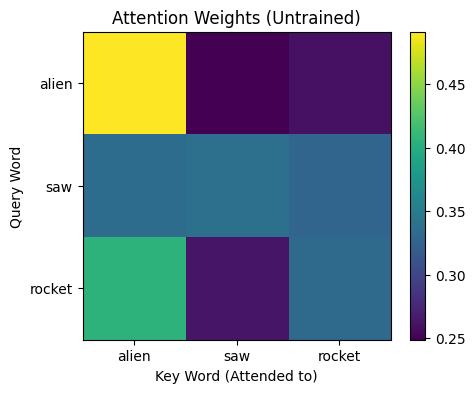

Shape of Output: torch.Size([1, 3, 8])


In [11]:
# Create embeddings for a specific sentence
test_sentence = "alien saw rocket"
test_tokens = tokenizer(test_sentence)
test_ids = [word2idx[t] for t in test_tokens]

embed_dim = 8
embedding_layer = nn.Embedding(len(vocab), embed_dim)
input_embeds = embedding_layer(torch.tensor([test_ids])) # Shape [1, 3, 8]

# Run Manual Attention
manual_attn = ManualSelfAttention(d_model=embed_dim)
output, weights = manual_attn(input_embeds)

# Plotting
w_matrix = weights[0].detach().numpy()

plt.figure(figsize=(5,4))
plt.imshow(w_matrix, cmap='viridis')
plt.xticks(range(len(test_tokens)), test_tokens)
plt.yticks(range(len(test_tokens)), test_tokens)
plt.colorbar()
plt.title("Attention Weights (Untrained)")
plt.ylabel("Query Word")
plt.xlabel("Key Word (Attended to)")
plt.show()

print("Shape of Output:", output.shape) # Should be [1, 3, 8]

## 3. Position Embeddings: Adding Space Coordinates

Attention is effectively a "bag of words" logic. "Rocket hits asteroid" and "Asteroid hits rocket" look the same to raw attention because it just sums up similarities.

To fix this, we add **Positional Embeddings**. These are unique vectors for Position 0, Position 1, etc., added to the word embeddings.

In [12]:
class SpaceTransformer(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim=32, num_heads=4):
        super().__init__()
        
        # 1. Token Embeddings (Word meaning)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # 2. Positional Embeddings (Word order)
        self.pos_embedding = nn.Embedding(seq_len, embed_dim)
        
        # 3. Multi-Head Attention (PyTorch optimized version)
        # We switch to nn.MultiheadAttention for efficiency and multiple heads
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # 4. Final Projection to Vocabulary
        self.fc = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, x):
        B, T = x.shape # Batch, Time(seq_len)
        
        # Create position indices [0, 1, 2...]
        positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        
        # Add Token + Position embeddings
        x = self.token_embedding(x) + self.pos_embedding(positions)
        
        # Attention
        # attn_output shape: [Batch, Seq, Dim]
        attn_output, attn_weights = self.attn(x, x, x)
        
        # We want to predict the next word based on the LAST token in the sequence
        last_token_output = attn_output[:, -1, :]
        
        # Project to vocabulary size
        logits = self.fc(last_token_output)
        
        return logits, attn_weights

## 4. The Main Mission: Training on Sci-Fi Logs

Now we create a slightly larger, more interesting dataset representing a "Captain's Log". We will train the model to generate pseudo-sci-fi text.

In [13]:
# A Mini Sci-Fi Corpus
scifi_corpus = """
captains log stardate 2025 we have entered the nebula
the nebula is filled with purple gas and static energy
sensors are detecting a signal from the unknown planet
shields are holding at fifty percent power captain
engage the warp drive to escape the black hole
the alien ship is hailing us on all frequencies
beam me up scotty the surface is toxic
the droid fixed the hyperdrive engine just in time
red alert all hands to battle stations immediately
we come in peace do not fire your lasers
the galaxy is vast and full of wonders
"""

# 1. Rebuild Vocab and Data with new corpus
vocab, word2idx, idx2word = build_vocab(scifi_corpus, tokenizer)
inputs, targets = create_sliding_windows(scifi_corpus, tokenizer, word2idx, seq_len=4)

# 2. Create PyTorch Dataset
class SciFiDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)
    def __len__(self): return len(self.inputs)
    def __getitem__(self, idx): return self.inputs[idx], self.targets[idx]

dataset = SciFiDataset(inputs, targets)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Training samples: {len(dataset)}")

Training samples: 52


### 4.1 The Training Loop

We use **CrossEntropyLoss** (standard for classification/text gen) and **Adam** optimizer.

In [14]:
model = SpaceTransformer(vocab_size=len(vocab), seq_len=4, embed_dim=32, num_heads=4)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

EPOCHS = 50

print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f}")

Starting Training...
Epoch 10 | Loss: 0.0207
Epoch 20 | Loss: 0.0038
Epoch 30 | Loss: 0.0018
Epoch 40 | Loss: 0.0011
Epoch 50 | Loss: 0.0007


## 5. Generating Space Logs

Now for the fun part. We will give the model a starting seed (e.g., "the alien ship") and ask it to complete the sentence.

We use a **Temperature** parameter. 
- High Temp (>1.0): Crazy, diverse, risky output.
- Low Temp (<1.0): Safe, repetitive, "confident" output.

In [15]:
def generate_text(model, start_text, length=10, temp=1.0):
    model.eval()
    tokens = tokenizer(start_text)
    # Pad if too short
    if len(tokens) < 4:
        tokens = ['<pad>'] * (4 - len(tokens)) + tokens
        
    current_ids = [word2idx.get(w, word2idx['<unk>']) for w in tokens]
    
    output_text = list(tokens)
    
    with torch.no_grad():
        for _ in range(length):
            # Get last 4 tokens for context
            in_seq = torch.tensor([current_ids[-4:]], device=device)
            
            logits, _ = model(in_seq)
            
            # Apply temperature
            logits = logits / temp
            probs = F.softmax(logits, dim=-1)
            
            # Sample from distribution
            next_token_id = torch.multinomial(probs, 1).item()
            next_word = idx2word[next_token_id]
            
            output_text.append(next_word)
            current_ids.append(next_token_id)
            
    return " ".join(output_text).replace("<pad> ", "")

# Test Generation
print("--- Generated Logs ---")
print("1. ", generate_text(model, "the alien ship", length=5))
print("2. ", generate_text(model, "engage the warp", length=6))
print("3. ", generate_text(model, "red alert", length=6))

--- Generated Logs ---
1.  the alien ship in us us the fifty
2.  engage the warp of toxic escape the do have
3.  red alert unknown full of fifty on do


## 6. Visualizing Learned Attention

Did the model actually learn anything meaningful? Let's visualize the attention map of a generated sentence to see which words the model focused on when making a decision.

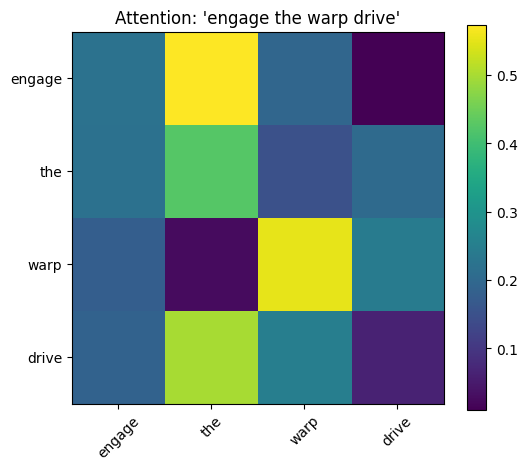

In [16]:
def show_attention(input_text):
    model.eval()
    tokens = tokenizer(input_text)
    ids = [word2idx.get(w, word2idx['<unk>']) for w in tokens]
    input_tensor = torch.tensor([ids], device=device)
    
    with torch.no_grad():
        logits, attn_weights = model(input_tensor)
    
    # attn_weights shape is [batch, seq_len, seq_len]
    # We take the first batch item
    w = attn_weights[0].cpu().numpy()
    
    plt.figure(figsize=(6,5))
    plt.imshow(w, cmap='viridis')
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.yticks(range(len(tokens)), tokens)
    plt.colorbar()
    plt.title(f"Attention: '{input_text}'")
    plt.show()

show_attention("engage the warp drive")

## Conclusion

You have successfully built a Transformer-based language model from the ground up! 

**Summary of what we built:**
1. **Vector Space**: We turned "Space Opera" text into numbers.
2. **Attention**: We implemented the math that allows the model to relate "warp" to "drive" and "alien" to "rocket".
3. **Training**: We optimized the model to predict the next word.

**Next Steps:**
- Try adding more text to the `scifi_corpus` to make the model smarter.
- Increase `embed_dim` and `num_heads` if you have a GPU.
- Try to generate a longer story!